In [2]:
import pandas
import numpy

import seaborn
from matplotlib import pyplot as plt

In [3]:


def load_dataset(path):

    df = pandas.read_csv(path)
    
    return df

   
path = './dataset/cards-cleaned-1.csv'
data = load_dataset(path)
data.head()

,filename,tick,r,g,b,button,section,label
0,cards-2hz-100ms-2.csv,36000,84.0,37.0,193.0,0.0,NaN,ambient
1,cards-2hz-100ms-2.csv,36500,83.0,36.0,192.0,0.0,NaN,ambient
2,cards-2hz-100ms-2.csv,37000,84.0,36.0,193.0,0.0,NaN,ambient
3,cards-2hz-100ms-2.csv,37500,83.0,35.0,191.0,0.0,NaN,ambient
4,cards-2hz-100ms-2.csv,38000,84.0,36.0,192.0,0.0,NaN,ambient


In [4]:
data.label.value_counts()

ambient      187
Purple        30
Black         29
Pink          29
Blue          29
Grey          28
Red           28
DarkBlue      28
PaleGreen     27
White         26
Yellow        25
Name: label, dtype: int64

In [31]:

def undersample_class(data, label='ambient', random_state=1, target = 30):
    
    data = data.copy() # avoid mutating input
    is_target = data['label'] == label
    sampled = data[is_target].sample(n=target, random_state=random_state)
    out = pandas.concat([ data[~is_target], sampled ])
    return out

cleaned = undersample_class(data)
cleaned = cleaned.dropna(subset=['label'])
cleaned.label.value_counts()

Purple       30
ambient      30
Black        29
Pink         29
Blue         29
Grey         28
Red          28
DarkBlue     28
PaleGreen    27
White        26
Yellow       25
Name: label, dtype: int64

In [223]:

# Train a RandomForest classifer on RGB space

from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

features = ['r', 'g', 'b']
label = 'label'

X = cleaned[features]
Y = cleaned[label]

est = sklearn.pipeline.make_pipeline(
    #StandardScaler(),
    PCA(2),
    RandomForestClassifier(n_estimators=10, min_samples_leaf=0.05, max_depth=5)
)

scores = cross_val_score(est, X=X, y=Y, scoring='accuracy', error_score='raise')
est.fit(X, Y)
scores




array([0.82258065, 1.        , 0.93548387, 0.93548387, 1.        ])

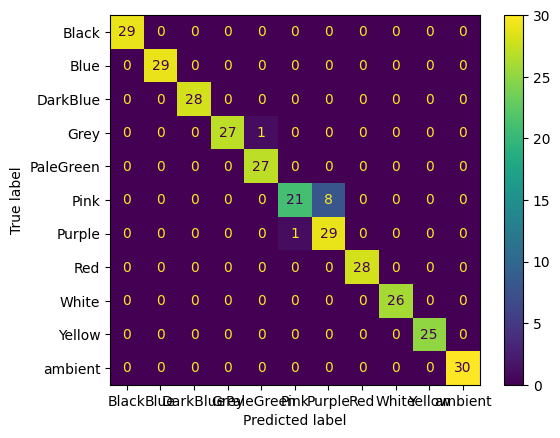

In [225]:

# plot a confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(est, X, Y)


In [226]:
# FIXME: load from dataset
card_data_order = [
    'Black',
    'White',
    'Grey', # cardboard
    'Pink',
    'Yellow',
    'Red',
    'PaleGreen',
    'Purple',
    'Blue',
    'DarkBlue',
]
def make_label_mapping(section_labels):

    label_mapping = {
        #numpy.nan: 'ambient'
    }
    for idx, label in enumerate(section_labels):
        label_mapping[idx] = label
    return label_mapping

label_mapping = make_label_mapping(card_data_order)
label_mapping

cards_color_map = dict(zip(label_mapping.values(), label_mapping.values()))
cards_color_map.update({
    'ambient': 'Sienna',
    'White': 'Beige', 
})
cards_color_map

{'Black': 'Black',
 'White': 'Beige',
 'Grey': 'Grey',
 'Pink': 'Pink',
 'Yellow': 'Yellow',
 'Red': 'Red',
 'PaleGreen': 'PaleGreen',
 'Purple': 'Purple',
 'Blue': 'Blue',
 'DarkBlue': 'DarkBlue',
 'ambient': 'Sienna'}

<AxesSubplot: xlabel='pca.1', ylabel='pca.2'>

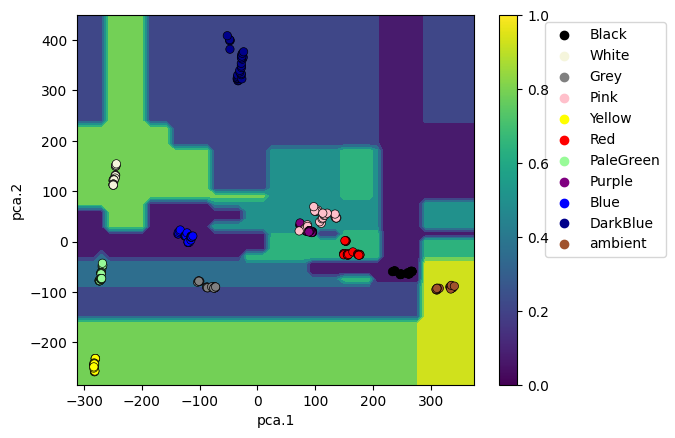

In [227]:

# Plot decision boundaries, in PCA 2d space

def pca_transform_2d(data, columns = ['r', 'g', 'b']):
    from sklearn.decomposition import PCA
  
    pca = PCA(2)
    data = data.dropna(subset=columns)
    
    X = data[columns]
    dd = pca.fit_transform(X)
    df = pandas.DataFrame(dd, columns=['pca.1', 'pca.2'], index=data.index)
    return df, pca

def plot_decision_surface(estimator, data,
                          x_steps=50, y_steps=50,
                         response_method="predict"):

    from sklearn.inspection import DecisionBoundaryDisplay
    from sklearn.preprocessing import LabelEncoder
    
    # Transform to 2d using PCA
    pca_data, pca = pca_transform_2d(data)
    pca1, pca2 = pca_data['pca.1'], pca_data['pca.2']
    
    feature_1, feature_2 = numpy.meshgrid(
        numpy.linspace(pca1.min() * 1.1, pca1.max() * 1.1, num=x_steps),
        numpy.linspace(pca2.min() * 1.1, pca2.max() * 1.1, num=y_steps)
    )
    pca_grid = numpy.vstack([feature_1.ravel(), feature_2.ravel()]).T

    # Make predictions in RGB space,
    rgb_grid = pandas.DataFrame(pca.inverse_transform(pca_grid), columns=['r', 'g', 'b'])
    
    if response_method == 'decision_function':
        y_pred = estimator.decision_function(rgb_grid)
    elif response_method == 'score_samples':
        y_pred = estimator.score_samples(rgb_grid)
    elif response_method == 'negative_outlier_factor_':
        y_pred = estimator.negative_outlier_factor_
    elif response_method == 'predict':
        # DecisionBoundaryDisplay breaks with string labels, convert to numerical
        le = LabelEncoder()
        y_pred = le.fit_transform(estimator.predict(rgb_grid))
    else:
        raise ValueError()
    y_pred = numpy.reshape(y_pred, feature_1.shape)

    #print(y_pred)
    
    display = DecisionBoundaryDisplay(
        xx0=feature_1,
        xx1=feature_2,
        response=y_pred
    )
    display.plot()

    ax = display.ax_
    # Show datapoints
    seaborn.scatterplot(ax=ax,
        x=pca1,
        y=pca2,
        hue=data['label'].values.astype(str),
        edgecolor="black",
        palette=cards_color_map,
    )
    ax.legend(bbox_to_anchor=(1.5, 1.00))
    
    plt.colorbar(ax.collections[1])
    
    return ax

plot_decision_surface(est, cleaned)

In [228]:
# TODO: use emlearn to convert, write C code output

<AxesSubplot: xlabel='pca.1', ylabel='pca.2'>

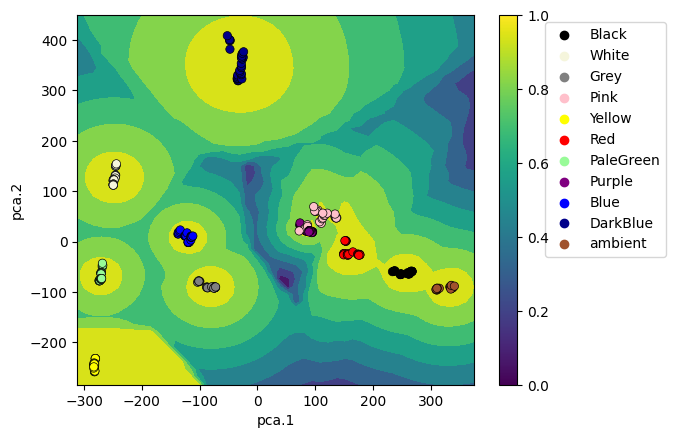

In [229]:
from sklearn.neighbors import LocalOutlierFactor
from sklearn.decomposition import PCA
import sklearn.pipeline  

detector = sklearn.pipeline.make_pipeline(
        PCA(2),
        LocalOutlierFactor(n_neighbors=25, novelty=True),
)
    
#detector = LocalOutlierFactor(n_neighbors=2, novelty=True)
#detector.fit(cleaned[cleaned.label == 'Pink'][features])
detector.fit(cleaned[features])
plot_decision_surface(detector, cleaned, response_method="score_samples")

<AxesSubplot: xlabel='pca.1', ylabel='pca.2'>

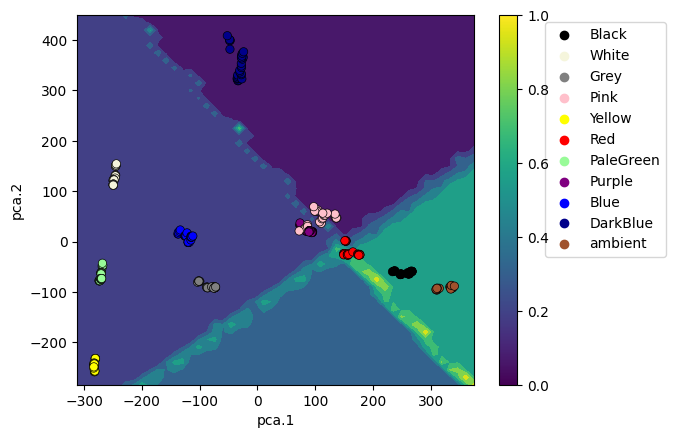

In [196]:
from sklearn.ensemble import IsolationForest

detector = sklearn.pipeline.make_pipeline(
        PCA(2),
        IsolationForest(n_estimators=100, contamination=0.1),
)

#detector = IsolationForest(n_estimators=100, contamination=0.001)
detector.fit(cleaned[cleaned.label == 'Red'][features])

plot_decision_surface(detector, cleaned, response_method="score_samples")